# Projeto 1 - Ciência dos Dados

Nome: joao Pedro De Souza Costa Ferreira

Nome: Paolo Martinati

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [120]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import operator
import functools
import emoji

In [121]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Pichau\Documents\faculdade\C dados\C dados semestre atual\Projeto 1


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [122]:
filename = 'netflix.xlsx'

In [123]:
train = pd.read_excel(filename)


In [124]:
test = pd.read_excel(filename, sheet_name = 'Teste')


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

ESCREVA AQUI...O nosso produto é o seviço de steaming netflix 
Classificamos como relevante todo tipo de sugestao para a marca (indicaóes de series, comparaçao com outro serviços de streaming,o que as pessoas comsomem quando estáo vendo netflix,obter informações sobre a opinião e aceitação (ou não) dos usuarios...)

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

#### lista para utilização futura do codigo

In [125]:

# stop words basicamente sao palavras aserem removidas que não representão algum ganho para o rpojeto
#lista de 'stopwords' para serem removidas depois:
stopwords = ['de','a','o','que','e','do','da','em','um','para','e','com','nao','uma','os','no','se',
             'na','por','mais','as','como','mas','foi','ao','ele','tem','a','sua','ou','ser','quando',
             'muito','ja','eu','isso','ela','era','depois','sem','mesmo','ter',
             'quem','me','esse','eles','tinha','essa','nem','meu','as','minha','tem','não','é','pra','só',
            'q','vou','pq','já','até','vai','fazer','acho','pelo','faz', ]


#Lista de palavras que nos interessam e serão usadas para comparação mais tarde.    
palavras_importantes = ['hbo max','amazon','disney','youtube','dorama','crunchyroll'\
               ,'streaming','breja','serie','recomendação','filme','the society','sense 8'
                'modern family','anime','chocolate','pipoca','casa de papel']   

#### funcoes iniciais 

In [126]:
#Função que aucilia na limpesa do material analizado, separando emojis de outros caracteres.        
def separa_emoji(lista):
    lista_separa_emoji = emoji.get_emoji_regexp().split(lista)
    lista_separa_espaco = [substr.split() for substr in lista_separa_emoji]
    lista_separa = functools.reduce(operator.concat, lista_separa_espaco)
    return lista_separa

def limpeza_texto(texto):
    #Retira as sequências de controle
    texto = texto.replace("\\n", '').replace("\n\n", '').replace("\n", '').replace("[", '').replace("]", '')
    #Parte "muito simples" retirado do material de aula.
    punctuation = '[!-..:?;_—•|/\‘’“”@#$%&₱༉‧₊˚~]' 
    pattern = re.compile(punctuation)
    texto_sub = re.sub(pattern, '', texto)
    #substitui as palavras "netflix" e "https" que nao interverem na relevancia da mensagem.
    texto_sub = texto_sub.replace("netflix",'').replace("https", '')
    return texto_sub



#### palavras mais relevantes e aplicando o smooth

In [127]:
# separando o data frame entre irrelevantes e relevantes só para separação de palavras 
TTrelevantes = train.loc[train.B1 == 1, :]
TTirrelevantes = train.loc[train.B1 == 0, :]

TTrelevantes.head()

#Relevantes

# Separando as palavras:
Lrelevantes = TTrelevantes.Treinamento.tolist()
palavras_relevantes = []
for tweet in Lrelevantes:
    palavras = tweet.split()
    palavras_relevantes += palavras
    
len(palavras_relevantes)

# Criando um dicionario com a contagem de palavras:
dic_relevantes = {}
for palavra in palavras_relevantes:
    if palavra in dic_relevantes:
        dic_relevantes[palavra] +=1
    else:
        dic_relevantes[palavra] = 1
dic_relevantes
relevantes = pd.DataFrame.from_dict(dic_relevantes, orient='index', columns=['Quantd'])

Lirrelevantes = TTirrelevantes.Treinamento.tolist()
palavras_irrelevantes = []
for tweet in Lirrelevantes:
    palavras = tweet.split()
    palavras_irrelevantes += palavras
    
len(palavras_irrelevantes)

# Criando um dicionario com a contagem de palavras:
dic_irrelevantes = {}
for palavra in palavras_irrelevantes:
    if palavra in dic_irrelevantes:
        dic_irrelevantes[palavra] +=1
    else:
        dic_irrelevantes[palavra] = 1
dic_irrelevantes
irrelevantes = pd.DataFrame.from_dict(dic_irrelevantes, orient='index', columns=['Quantd'])


palavras = relevantes + irrelevantes

# utilizando cont do tamanho da lista para o proximo passo 
total_relevantes = len(relevantes.index)
total_irrelevantes = len(irrelevantes.index)
total_palavras = len(palavras.index)

# para serapração de palavras retiramos algumas que não oferecem quallidade ao projeto e aplicamos o smooth 
relevantes['Probabilidade (smooth)'] = (relevantes.Quantd+1)/(total_relevantes + total_palavras)
x=relevantes.drop(stopwords).drop('netflix').drop('netflix.').drop('netflix,').drop('the').drop('@seriesbrasil')
x.sort_values(by='Quantd',ascending=False).head(10)



,Quantd,Probabilidade (smooth)
série,17,0.005778
assistir,16,0.005457
society,12,0.004173
filme,11,0.003852
casa,10,0.003531
ver,9,0.003210
papel,9,0.003210
nunca,8,0.002889
la,7,0.002568
vendo,6,0.002247


#### separando o dataframe em listas de relevantes e irrelevantes

In [128]:
#separando o dataframe em dois novamente para o classificador,de acordo com a relevancia feita na coragem.
train_relevantes = train.loc[train.B1 == 1]
train_irrelevantes = train.loc[train.B1== 0]

#Estas funções fazem com que o conteúdo por inteiro seja exposto. 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#### criando as listas e tabelas de relevantes e irrelevantes aplicando as funções e as modificações

In [129]:
# Relevantes 
#"lista_relevante" é uma enore lista com todos os tweeets relevantes, ja a funcao limpezade texto.
lista_relevante = limpeza_texto(str(train_relevantes.Treinamento))
#agora aplica-se a função que separa caracteres colados em emojis
lista_relevante = separa_emoji(lista_relevante.lower())
#"serie_relevante" é um novo dataframe com todas as palavras reparadas.
serie_relevante = pd.Series(lista_relevante)
#criando uma tabela com a contagem da quantidade de cada palavra. Depois, retira as stopwords.
tabela_relevantes = serie_relevante.value_counts()
tabela_relevantes = tabela_relevantes.drop(labels=stopwords)

# Irrelevantes 
#Agora o mesmo para as irrelevantes.
lista_irrelevante = limpeza_texto(str(train_irrelevantes.Treinamento))
lista_irrelevante = separa_emoji(lista_irrelevante.lower())
serie_irrelevante = pd.Series(lista_irrelevante)
tabela_irrelevantes = serie_irrelevante.value_counts()
tabela_irrelevantes = tabela_irrelevantes.drop(labels=stopwords)

In [130]:
# Conjunto completo 
#agora o mesmo para o conjunto completo
lista_completa = limpeza_texto(str(train.Treinamento))
lista_completa = separa_emoji(lista_completa.lower())
serie_completa = pd.Series(lista_completa)
tabela_completa = serie_completa.value_counts()
tabela_completa = tabela_completa.drop(labels=stopwords)


#Calculando as probabilidades da palavra ser relevante ou irrelevante dado o conjunto completo.
P_rel = len(serie_relevante)/len(serie_completa)
P_irrel = 1 - P_rel

#### criando  funções para calcular probabilidade  (classificador naivy bayes) e aplicando


In [131]:
#Essa funçao calcula a probabilidade de uma dada palavra estar no grupo relevante e de estar no grupo irrelevante.
def calcula_probabilidades(palavra):

    if palavra in tabela_relevantes:
        R = tabela_relevantes[palavra]
    else:
        R = 0
        
    if palavra in tabela_irrelevantes:
        I = tabela_irrelevantes[palavra]
    else:
        I = 0           
            
    Rel_p = (R + 1) / (len(lista_relevante) + 1*len(train))
    Irrel_p = (I + 1) / (len(lista_irrelevante) + 1*len(train))
    return [Rel_p, Irrel_p] #  Rel_p = P(palavra|Relevantes)  ||  Irrel_p = P(palavra|Irrelevantes)

#Essa funçao usa a anterior para calcular a probabilidade de uma dada frase, por palavra, estar no grupo relevante e
#de estar no grupo irrelevante. Então as compara e retorna a relevância da frase.
def compara_probabilidades(frase):
    frase = separa_emoji(limpeza_texto(str(frase)).lower())
    Rel = 1
    Irrel = 1    
    for palavra in frase:
        Rel *= calcula_probabilidades(palavra)[0]
        Irrel *= calcula_probabilidades(palavra)[1]
    if Rel >= Irrel:
        return 1
    else:
        return 0

In [132]:
#aplicando funções
lista_teste = []
for e in test['Teste']:
    lista_teste.append(compara_probabilidades(e))
    
test["classificador"] = lista_teste


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

#### testando o classificador e separando nas classificações

In [133]:
#"comparados" é uma tabela comparativa dos valores de relevancia atribuidos manualmente e pelo classificador
comparados = pd.crosstab(test['B1'],test['classificador'], normalize='index')

#separando os valores da tabela 
pos_true = comparados[1][1]/2
pos_false = comparados[1][0]/2
neg_true = comparados[0][0]/2
neg_false =comparados[0][1]/2

print("-"*40)
print("Verdadeiros positivos: ", round(pos_true*100,2), "%")
print("Falsos positivos: ", round(pos_false*100, 2), "%")
print("Verdadeiros negativos: ", round(neg_true*100,2), "%")
print("Falsos negativos: ", round(neg_false*100, 2), "%")
print("-"*40)

print("Acertos: ", round((pos_true+neg_true)*100,2), "%")
print("Erros: ", round((pos_false+neg_false)*100,2), "%")
print("-"*40)

----------------------------------------
Verdadeiros positivos:  26.14 %
Falsos positivos:  13.39 %
Verdadeiros negativos:  36.61 %
Falsos negativos:  23.86 %
----------------------------------------
Acertos:  62.74 %
Erros:  37.26 %
----------------------------------------


#### incrementando com a por das classificações

In [134]:
#criando tabelas separadas com os valores de relevância
test_relevantes = test.loc[test.B1 == 1]
test_irrelevantes = test.loc[test.B1== 0]

print("-"*70)
print("Verdadeiros positivos: ", round(pos_true*100,2), "%")
print("Falsos positivos: ", round(pos_false*100, 2), "%")
print("Verdadeiros negativos: ", round(neg_true*100,2), "%")
print("Falsos negativos: ", round(neg_false*100, 2), "%")
print("-"*70)

print("Classificados como Relevantes (código): ", round((pos_true+pos_false)*100,2), "%")
print("Classificados como Irelevantes (código): ", round((neg_true+neg_false)*100,2), "%")
print("")
print("Classificados como Relevantes (Manualmente): ", round((len(test_relevantes)/len(test))*100,2), "%")
print("Classificados como Irelevantes (Manualmente): ", round((len(test_irrelevantes)/len(test))*100,2), "%")
print("-"*70)

print("Acertos: ", round((pos_true+neg_true)*100,2), "%    (verdadeiros positivos e verdadeiros negativos)")
print("Erros: ", round((pos_false+neg_false)*100,2), "%    (falsos positivos e falsos negativos)")
print("-"*70)



----------------------------------------------------------------------
Verdadeiros positivos:  26.14 %
Falsos positivos:  13.39 %
Verdadeiros negativos:  36.61 %
Falsos negativos:  23.86 %
----------------------------------------------------------------------
Classificados como Relevantes (código):  39.53 %
Classificados como Irelevantes (código):  60.47 %

Classificados como Relevantes (Manualmente):  44.0 %
Classificados como Irelevantes (Manualmente):  56.0 %
----------------------------------------------------------------------
Acertos:  62.74 %    (verdadeiros positivos e verdadeiros negativos)
Erros:  37.26 %    (falsos positivos e falsos negativos)
----------------------------------------------------------------------


#### plotando grafico proporção relevantes e irrelevantes

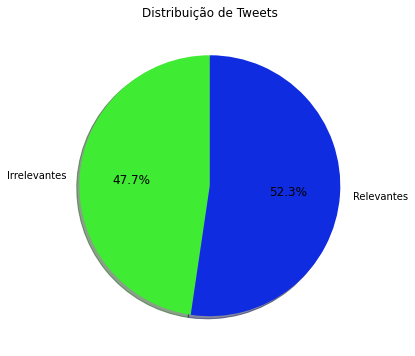

In [135]:
lc=[]
for i in train['B1']:
    lc.append(i)

c_irrelevante=lc.count(0)    
c_relevante=lc.count(1) 

fig, asd = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
relevancia0 = ['Irrelevantes', 'Relevantes']
data0 = [c_irrelevante, c_relevante]
c0 = ['#40eb34', '#102ce0']
wedges, texts, autotexts = asd.pie(data0,  labels=relevancia0, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=c0)
plt.setp(autotexts, size=12)
asd.set_title("Distribuição de Tweets")

plt.show()

#### platando grafico dos classificador dos tweets

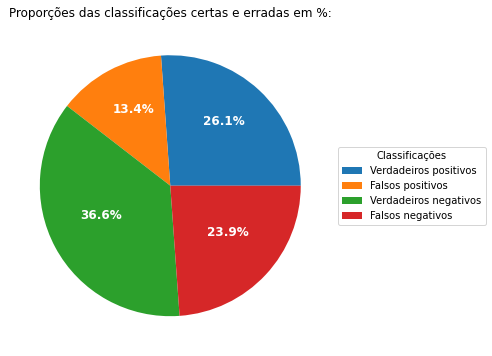

In [138]:
# Gráfico 
# Aqui criamos a área que plotamos o gráfico e definimos seu tamanho
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal",))

# Definindo dados para compor o gráfico a quantidade de cada um
recipe = ["Verdadeiros positivos","Falsos positivos","Verdadeiros negativos","Falsos negativos"]
data = [pos_true, pos_false, neg_true, neg_false]

# Aqui serão colocados as porcentagens no gráfico
def grafico(pct, allvals):
    # calc %
    absolute = int(pct/100.*np.sum(allvals))
    # fazendo legenda do gráfico com % e kg
    return "{:.1f}%\n".format(pct, absolute)

# Criando o gráfico e colocando a função da legenda interna
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: grafico(pct, data),
                                  textprops=dict(color="w",))
# Definindo a caixa de legenda externa, título, localização e onde vai 'ancorar o box'
ax.legend(wedges, recipe,
          title="Classificações",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
# Aqui definimos o tamanho do texto de dentro do gráfico, e o peso da fonte como bold
plt.setp(autotexts, size=12, weight="bold",)
# Título do gráfico
ax.set_title("Proporções das classificações certas e erradas em %:")
# Mostrando o gráfico
plt.show()

___
### Concluindo


Podemos concluir que o nosso classificador tem um resultado satisfatorio pois apresenta uma acuracia acima de 50%.Alem disso porcentagens de 'verdadeiro positivo'e 'verdadeiro negativo'apresentarem maior porcentagem do nosso classificador apesar de ter um porcentagem siginificativa de falsos negativos. Uma possível solução para esse problema seria obter mais tweets para a base de treinamento do codígo, afim de tornar esse "critério vago" em algo mais claro em termos de quantidade de palavras.

### classificação avançada

----------------------------------------
Resultado da Classificação Avançada:
----------------------------------------
Irrelevantes:  50.0 %
Relevantes:  32.5 %
Muito Relevantes:  1.0 %
Destaques:  16.5 %
----------------------------------------


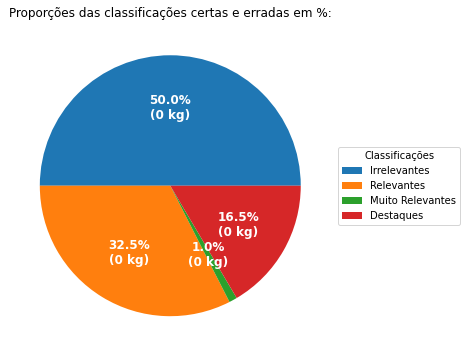

In [137]:
#Essa funçao usa a mesma função "calcula_probabilidades"de antes, para calcular a probabilidade de uma dada frase,
# por palavra, estar no grupo relevante e de estar no grupo irrelevante. Então as compara e retorna a relevância da frase
# de acordo com os novos criterios descritos acima.
def compara_probabilidades_avançado(frase):
    frase = separa_emoji(limpeza_texto(str(frase)).lower())
    Rel = 1
    Irrel = 1    
    for palavra in frase:
        Rel *= calcula_probabilidades(palavra)[0]
        Irrel *= calcula_probabilidades(palavra)[1]
        if palavra in palavras_importantes:
            return 3    
    if Rel/Irrel > 1000:
        return 2
    elif Rel >= Irrel:
        return 1
    else:
        return 0

#aplicando as funções
lista_teste_avançado = []
for e in test['Teste']:
    lista_teste_avançado.append(compara_probabilidades_avançado(e))
test["classificador_avançado"] = lista_teste_avançado

Classificador_avançado = test.classificador_avançado.value_counts(normalize=True, sort=False)

print("-"*40)
print("Resultado da Classificação Avançada:")
print("-"*40)
Irrelevantes_A = Classificador_avançado[0]
Relevantes_A = Classificador_avançado[1]
muito_relevantes_A = Classificador_avançado[2]
detaque_A = Classificador_avançado[3]

print("Irrelevantes: ", round(Irrelevantes_A*100,2), "%")
print("Relevantes: ", round(Relevantes_A*100,2), "%")
print("Muito Relevantes: ", round(muito_relevantes_A*100,2), "%")
print("Destaques: ", round(detaque_A*100,2), "%")
print("-"*40)

# Gráfico 
# Aqui criamos a área que plotamos o gráfico e definimos seu tamanho
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

# Definindo dados para compor o gráfico a quantidade de cada um
recipe = ["Irrelevantes","Relevantes","Muito Relevantes","Destaques"]
data = [Irrelevantes_A, Relevantes_A, muito_relevantes_A, detaque_A]

# Aqui serão colocados as porcentagens no gráfico
def grafico(pct, allvals):
    # calc %
    absolute = int(pct/100.*np.sum(allvals))
    # fazendo legenda do gráfico com % e kg
    return "{:.1f}%\n({:d} kg)".format(pct, absolute)

# Criando o gráfico e colocando a função da legenda interna
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: grafico(pct, data),
                                  textprops=dict(color="white"))
# Definindo a caixa de legenda externa, título, localização e onde vai 'ancorar o box'
ax.legend(wedges, recipe,
          title="Classificações",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
# Aqui definimos o tamanho do texto de dentro do gráfico, e o peso da fonte como bold
plt.setp(autotexts, size=12, weight="bold")
# Título do gráfico
ax.set_title("Proporções das classificações certas e erradas em %:")
# Mostrando o gráfico
plt.show()

### __Uso do próprio classificador para gerar amostras de treinamento:__ <br>



não pode-se usar tweets analisados pelo classificador como novas amostras de treinamento para aperfeiçoa-lo,  pois os erros do classificador (trazidos pela nova amostra) aumentariam drasticamente des-de a sua origem. Assim com a propagassao desses erros causaria um criterio cada vez mais distante do inivial e um erro cada vez maior gerando um aporcentagem de imprecisão elevada  

### diferentes cenarios para naive bayes

O classificador desses poderia ser usado para medir o quanto cada candidato a predisencia por exemplo está sendo comentado nas redes sociais.Um outro viez dessa pesquisa poderia ser tambem qual assunto que mais acompanha o presidente nas redes sociais.Um classificador desse pode ser utilizado tambem so setor turistico buscando localizar pontos destaque mais comentados nas redes sociais para possivel abertura de hoteis comercio etc...

### como aperfeiçoar ainda mais



vizando melhorar ainda mais o classificador alem de aumentar a base de treinamento e possuir um criterio mais claro e menos abrangente, começar a analisar frases com sarcarmo e ironia não realizadas pelo codigo atual, sendo necessario por exemplo analisar os significados dos emojis e a montagem da frase 

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

 separação dos Emojis:
https://stackoverflow.com/questions/49921720/how-to-split-emoji-from-each-other-python

 gráficos: \https://github.com/matheusbattisti/pie_charts/blob/master/piechart.ipynb